In [1]:
import os
import geopandas as gnd
import requests
import pandas as pd
import folium
import matplotlib.pyplot as plt

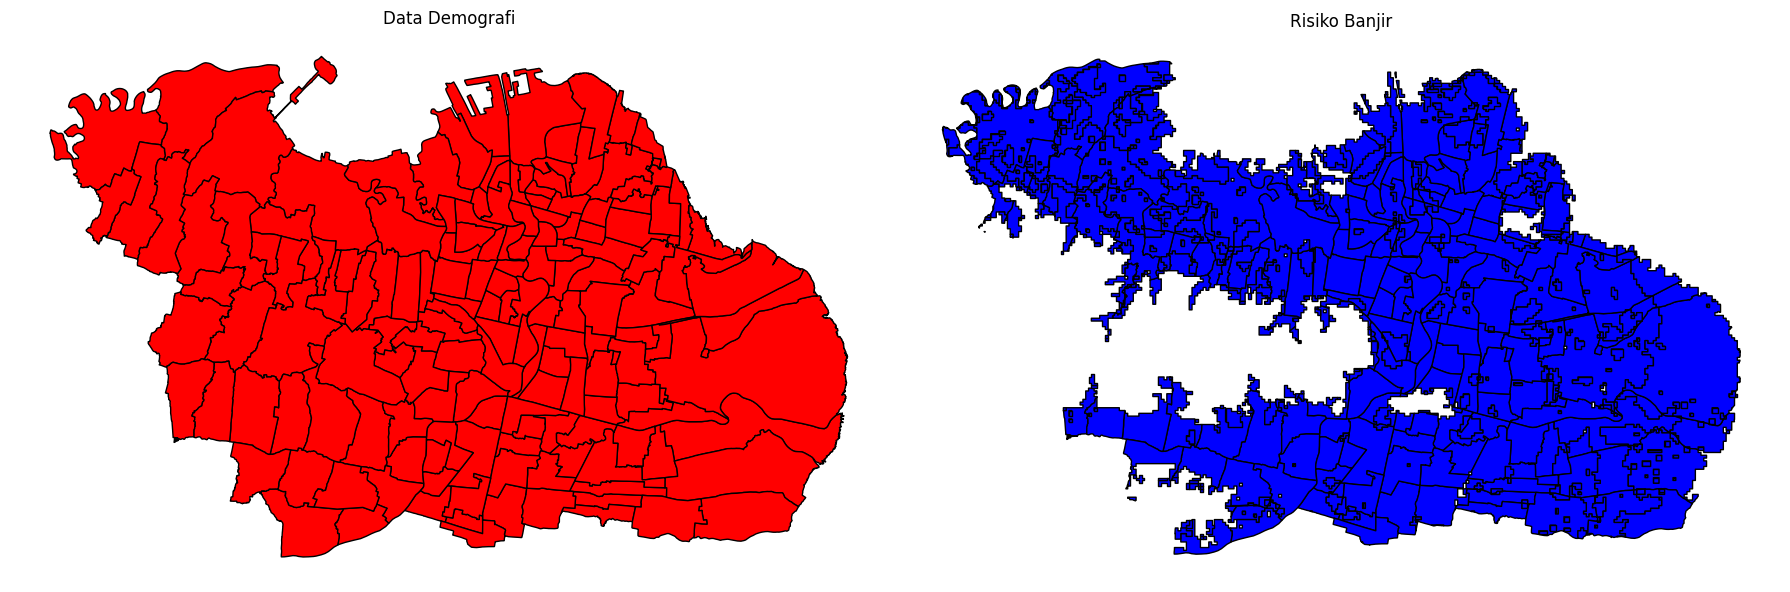

In [24]:
#get data api

urls = {"Demografi" : "https://geoserver.mapid.io/layers_new/get_layer?api_key=386ea08700ee4862ba94c2ff935b9464&layer_id=68aef65bb2fcc5561a32ca97&project_id=68a864a07fc5af9b4e424280&limit=10000",
"Risiko Banjir" : "https://geoserver.mapid.io/layers_new/get_layer?api_key=386ea08700ee4862ba94c2ff935b9464&layer_id=68aef665b2fcc5561a32cc8a&project_id=68a864a07fc5af9b4e424280&limit=10000"
}   

#menambahkan kolomr skor
def get_data(url, layer_name):
    response = requests.get(url)
    if response.status_code == 200:
        geojson_data = response.json()
        gdf = gnd.GeoDataFrame.from_features(geojson_data['features'])

        #menambahkan kolom skor berdasarkan variabel data
        if layer_name == "Demografi":
            gdf['SKOR_DEMOGRAFI'] = gdf.get("KELAS","").str.upper().map({
                "RENDAH": 1,
                "SEDANG": 2,
                "TINGGI": 3
            }).fillna(0)
        elif layer_name == "Risiko Banjir":
             gdf['SKOR_BANJIR'] = gdf.get("KELAS_RISIKO","").str.upper().map({
                "RENDAH": 3,
                "SEDANG": 2,
                "TINGGI": 1
            }).fillna(0)
            
        return gdf
    return gnd.GeoDataFrame

#mengambil data dari semua layer
gdf_demografi = get_data(urls["Demografi"], "Demografi")
gdf_banjir = get_data(urls["Risiko Banjir"], "Risiko Banjir")

#visualisasi data variabel menggunakan matplotlib

def visualize_data(gdfs):
    fig, axes = plt.subplots(1, len(gdfs), figsize=(18, 6))
    color_map = ['red',  'blue']
    for ax, ((name, gdf), color) in zip(axes, zip(gdfs.items(), color_map)):
        gdf.plot(ax=ax, color=color, edgecolor='black')
        ax.set_title(name)
        ax.set_axis_off()
    plt.tight_layout()
    plt.show()

#menampilkan visual dari ketika variabel
visualize_data({
    "Data Demografi": gdf_demografi,
    "Risiko Banjir": gdf_banjir
})

In [34]:
import requests
import geopandas as gpd
import pandas as pd

# URL API
urls = {
    "Demografi": "https://geoserver.mapid.io/layers_new/get_layer?api_key=386ea08700ee4862ba94c2ff935b9464&layer_id=68aef65bb2fcc5561a32ca97&project_id=68a864a07fc5af9b4e424280&limit=10000",
    "Risiko Banjir": "https://geoserver.mapid.io/layers_new/get_layer?api_key=386ea08700ee4862ba94c2ff935b9464&layer_id=68aef665b2fcc5561a32cc8a&project_id=68a864a07fc5af9b4e424280&limit=10000"
}

# Fungsi ambil data + skor
def get_data(url, layer_name):
    resp = requests.get(url)
    gdf = gpd.GeoDataFrame.from_features(resp.json()["features"])

    # Normalisasi string
    for col in gdf.columns:
        if gdf[col].dtype == "object":
            gdf[col] = gdf[col].astype(str).str.strip().str.upper()

    if layer_name == "Demografi":
        gdf["SKOR_DEMOGRAFI"] = gdf.get("KELAS", "").map({
            "RENDAH": 1,
            "SEDANG": 2,
            "TINGGI": 3
        }).fillna(0)

    elif layer_name == "Risiko Banjir":
        gdf["SKOR_BANJIR"] = gdf.get("KELAS_RISIKO", "").map({
            "RENDAH": 3,
            "SEDANG": 2,
            "TINGGI": 1
        }).fillna(0)

    return gdf

# Ambil data
gdf_demografi = get_data(urls["Demografi"], "Demografi")
gdf_banjir = get_data(urls["Risiko Banjir"], "Risiko Banjir")

# Intersect overlay
intersection_gdf = gpd.overlay(gdf_demografi, gdf_banjir, how="intersection")

# Pastikan kolom skor ada
for col in ["SKOR_DEMOGRAFI", "SKOR_BANJIR"]:
    if col not in intersection_gdf.columns:
        intersection_gdf[col] = 0
    intersection_gdf[col] = intersection_gdf[col].fillna(0)

# Hitung total
intersection_gdf["SKOR_TOTAL"] = (
    intersection_gdf["SKOR_DEMOGRAFI"] + intersection_gdf["SKOR_BANJIR"]
)

# Klasifikasi sederhana (3 level)
intersection_gdf["KESESUAIAN"] = pd.cut(
    intersection_gdf["SKOR_TOTAL"],
    bins=[0, 2, 4, 6],   # karena range total max 6
    labels=["RENDAH", "SEDANG", "TINGGI"],
    include_lowest=True
)

# Tampilkan hanya kolom yang diminta
print(intersection_gdf[["SKOR_DEMOGRAFI", "SKOR_BANJIR", "SKOR_TOTAL", "KESESUAIAN"]].head(10))


   SKOR_DEMOGRAFI  SKOR_BANJIR  SKOR_TOTAL KESESUAIAN
0             0.0            1         1.0     RENDAH
1             0.0            1         1.0     RENDAH
2             0.0            1         1.0     RENDAH
3             0.0            1         1.0     RENDAH
4             0.0            1         1.0     RENDAH
5             0.0            3         3.0     SEDANG
6             0.0            3         3.0     SEDANG
7             0.0            3         3.0     SEDANG
8             0.0            3         3.0     SEDANG
9             0.0            3         3.0     SEDANG


c:\Users\HP ELITEBOOK\Documents\pythongis\WEBGIS_ACADEMY\Lib\site-packages\geopandas\tools\overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 1182 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)


In [33]:
# Simpan ke geojson

import os

output_dir = r"C:\Users\HP ELITEBOOK\Downloads"
os.makedirs(output_dir, exist_ok=True)

# Ambil data multipolygon dan polygon
intersection_gdf_polygon = intersection_gdf[intersection_gdf.geometry.type.isin(['polygon', 'MultiPolygon'])]

# Memperbaiki geometry
intersection_gdf_polygon['geometry'] = intersection_gdf_polygon['geometry'].apply(lambda x: x.make_valid() if not x.is_valid else x)

# simpan data geojson
intersection_gdf_polygon.to_file(os.path.join(output_dir, "Hasil_intersect_task6.geojson"), driver='GeoJSON')

print (f"data berhasil")


c:\Users\HP ELITEBOOK\Documents\pythongis\WEBGIS_ACADEMY\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\HP ELITEBOOK\Documents\pythongis\WEBGIS_ACADEMY\Lib\site-packages\pyogrio\geopandas.py:710: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


data berhasil
